## Training SCSS-Net on coronal holes
In this notebook, we provide script to train SCSS-Net to segment coronal holes on 195A cropped images.   
Training process is shown at the bottom   
More on evaluating SCSS-net output in evaulating_SCSS-net.ipynb file and evaulating96-21_SCSS-net.ipynb

In [1]:
import sys, os
sys.path.append('../src/')

In [2]:
import numpy as np
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow
from keras.callbacks import ModelCheckpoint

In [3]:
from model_scss_net import scss_net
from metrics import dice_np, iou_np, dice, iou
from utils import plot_imgs, plot_metrics

In [7]:
# define hyperparameters
IMG_SIZE = 256  # resize imgs to 256x256
BATCH_SIZE = 20 # set batch size
SEED = 42       # set seed for reproducibility
EPOCHS = 100    # Set number of epochs

# specify model filename, you should rewrite MODEL_NAME as yours preferrings
MODEL_NAME = "model_filename"
model_filename = f"{MODEL_NAME}.h5"   

## DATA PREP

In [8]:
imgs = glob.glob("../data/train_test_data/CH_train_imgs/*.png")
masks = glob.glob("../data/train_test_data/CH_train_masks/*.png")

print(f"Imgs number = {len(imgs)}\nMasks number = {len(masks)}")

imgs_list = []
masks_list = []
for image, mask in zip(imgs, masks):
    imgs_list.append(np.array(Image.open(image).convert("L").resize((IMG_SIZE, IMG_SIZE))))
    masks_list.append(np.array(Image.open(mask).convert("L").resize((IMG_SIZE, IMG_SIZE))))



Imgs number = 2619
Masks number = 2619


In [9]:
# Normalization from (0; 255) to (0; 1)
x = np.asarray(imgs_list, dtype=np.float32)/255
y = np.asarray(masks_list, dtype=np.float32)/255

# Reshape to (n_imgs, height, width, channels)
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)
y = y.reshape(y.shape[0], y.shape[1], y.shape[2], 1)

In [10]:
# create validation dataset
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=123, shuffle=True)

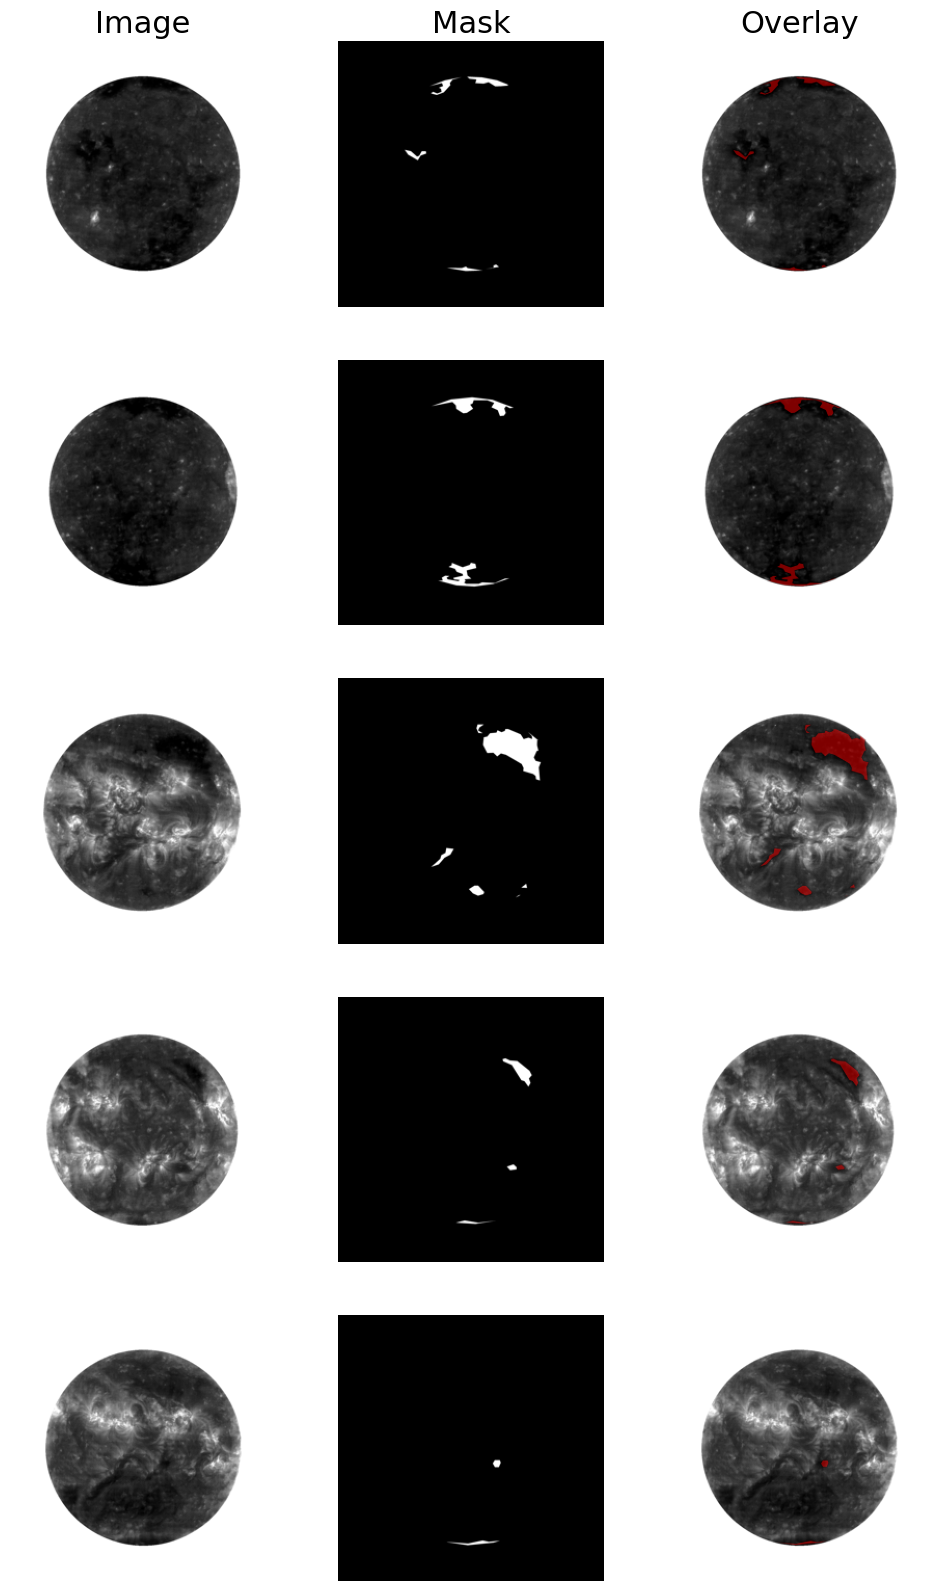

In [12]:
# plot prepared images with coresponding masks
plot_imgs(imgs=x, masks=y, n_imgs=5).show()

In [13]:
# input shape should be (256, 256, 1)
input_shape = x_train[0].shape
print(f"Input shape: {input_shape}\nTrain shape: {x_train.shape}  Val shape: {x_val.shape}")

Input shape: (256, 256, 1)
Train shape: (2095, 256, 256, 1)  Val shape: (524, 256, 256, 1)


## TRAINING SCSS MODEL

In [ ]:
# Load model architecture with optimal parameteres
model = scss_net( 
    input_shape,
    filters=32,       
    layers=4,
    batch_norm=True,
    drop_prob=0.5)

# Compile model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",  
    metrics=[iou, dice])

# Set steps parameters acording to size of training set and size of batch
STEPS = x_train.shape[0] // BATCH_SIZE        

# Set Callback that saves only best weights
callback_checkpoint = ModelCheckpoint(
    model_filename,
    verbose=1,
    monitor="val_loss",
    save_best_only=True)

In [2]:
# Train model, uncoment following lines to train
# history = model.fit(
#    x_train,
#    y_train,
#    steps_per_epoch=STEPS,
#    epochs=EPOCHS,
#    validation_data=(x_val, y_val),
#    callbacks=[callback_checkpoint],
#    verbose=2)

# # Plot training history (Metrics and Loss)
# plot_metrics(history).show()

In [30]:
# load pretrained weights
model.load_weights("ch_model.h5")

## Training process

<img src="../figures/training_processCH.png"  width="1200" height="120"> 

<img src="../figures/training_graphCH.png"  width="908" height="280">   

training with 2095 images took approx. 22 hours on Macbook pro M1 whitout GPU

Sample of segmented coronal holes   

<img src="../figures/CH-predicted.png"  width="1800" height="8000">  